In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats import linregress
from scipy.stats.stats import pearsonr
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
import higra as hg
import scipy.ndimage as si
from skimage import measure
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
%matplotlib inline

# Instance segmentation post-processing

## Helper functions

In [2]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Instance metrics

In [3]:
splits_path = '../data/splits/india_planetImagery_splits_20x20_v2.csv'
splits_df = pd.read_csv(splits_path, dtype=str)
splits_df['image_id'] = splits_df['image_id'].str.zfill(4)

In [4]:
train_ids = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
test_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values

## IoU

In [5]:
def get_IoUs(extent_true, extent_pred, boundary_pred, t_ext=0.4, 
             t_bound=0.2, plot=False):
    
    # get predicted instance segmentation
    instances_pred = InstSegm(extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
    instances_pred = measure.label(instances_pred, background=-1)
    
    # get instances from ground truth label
    instances_true = extent_true
    # binary_true = extent_true > 0
    # instances_true = measure.label(binary_true, background=0, connectivity=1)
    
    # remove non-cropland
    # kernel = np.ones((2,2), np.uint8)
    # cropland_mask = si.binary_closing(binary_true, structure=kernel, 
    #                                   iterations=4, border_value=1)
    # instances_pred = instances_pred * cropland_mask
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(instances_true)
        ax[1].imshow(instances_pred)
        plt.show()
    
    # loop through true fields
    field_values = np.unique(instances_true)
    best_IoUs = []
    field_sizes = []
    
    for field_value in field_values:
        if field_value == 0:
            continue # move on to next value
            
        this_field = instances_true == field_value
        field_sizes.append(np.sum(this_field))
        
        # find predicted fields that intersect with true field
        intersecting_fields = this_field * instances_pred
        intersect_values = np.unique(intersecting_fields)
        
        intersect_fields = np.isin(instances_pred, intersect_values[1:])
        
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(this_field)
            ax[1].imshow(intersect_fields)
            plt.show()
        
        # compute IoU for each intersecting field
        field_IoUs = []
        for intersect_value in intersect_values:
            if intersect_value == 0:
                continue # move on to next value
            pred_field = instances_pred == intersect_value
            union = this_field + pred_field > 0
            intersection = (this_field * pred_field) > 0
            IoU = np.sum(intersection) / np.sum(union)
            field_IoUs.append(IoU)
    
        # take maximum IoU - this is the IoU for this true field
        if len(field_IoUs) > 0:
            best_IoUs.append(np.max(field_IoUs))
        else:
            best_IoUs.append(0)
    
    return best_IoUs, field_sizes

## Planet

### Hyperparameter tuning

In [9]:
# hyperparameter values
t_exts = np.linspace(0.4, 0.7, 4)
t_bounds = np.linspace(0.0, 0.2, 3)

# run for all test fields
image_ids = val_ids

# Planet India
label_dir = '../data/planet/india/GeneralBlockchain/extent_labels_val_for_IoU/'
results_dirs = [
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/', # France 1x
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/', # France 2x+3x
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/consensus/', # India fine-tuned 
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch/consensus/' # India from scratch
]

for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    mIoUs = []
    IoU_50s = []
    all_IoUs = []
    mFieldSizes = []
    all_FieldSizes = []
    
    for t_ext in t_exts:
        for t_bound in t_bounds:
            print("  t_ext: {}, t_bound: {}".format(t_ext, t_bound))
            IoUs = []
            field_sizes = []

            for i, image_id in enumerate(image_ids):
                if i % 100 == 0:
                    print("    ", i)
                # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
                label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
                if os.path.exists(label_path):
                    # example_truth = imageio.imread(label_path)
                    example_truth = np.load(label_path)[:256,:256]
                    extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
                    boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
                    img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
                    IoUs = IoUs + img_IoUs
                    field_sizes = field_sizes + img_field_sizes

            mIoUs.append(np.median(IoUs))
            IoU_50s.append(np.sum(np.array(IoUs) > 0.5) / len(IoUs))
            all_IoUs.append(" ".join(["{:.4f}".format(x) for x in IoUs]))
            
            mFieldSizes.append(np.median(field_sizes))
            all_FieldSizes.append(" ".join([str(x) for x in field_sizes]))

    hp_df = pd.DataFrame({
        't_ext': np.repeat(t_exts, len(t_bounds)),
        't_bound': np.tile(t_bounds, len(t_exts)),
        'mIoU': mIoUs,
        'IoU_50': IoU_50s
    })
    hp_df.to_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'), index=False)
    print(hp_df.iloc[hp_df['IoU_50'].idxmax()])

fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759
  t_ext: 0.4, t_bound: 0.0
     0
     100
     200
  t_ext: 0.4, t_bound: 0.1
     0
     100
     200
  t_ext: 0.4, t_bound: 0.2
     0
     100
     200
  t_ext: 0.5, t_bound: 0.0
     0
     100
     200
  t_ext: 0.5, t_bound: 0.1
     0
     100
     200
  t_ext: 0.5, t_bound: 0.2
     0
     100
     200
  t_ext: 0.6, t_bound: 0.0
     0
     100
     200
  t_ext: 0.6, t_bound: 0.1
     0
     100
     200
  t_ext: 0.6, t_bound: 0.2
     0
     100
     200
  t_ext: 0.7, t_bound: 0.0
     0
     100
     200
  t_ext: 0.7, t_bound: 0.1
     0
     100
     200
  t_ext: 0.7, t_bound: 0.2
     0
     100
     200
t_ext      0.500000
t_bound    0.000000
mIoU       0.416667
IoU_50     0.380187
Name: 3, dtype: float64
fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759
  t_ext: 0.4, t_bound: 0.0
     0
     100
     200
  t_ext: 0.4, t_bound: 0.

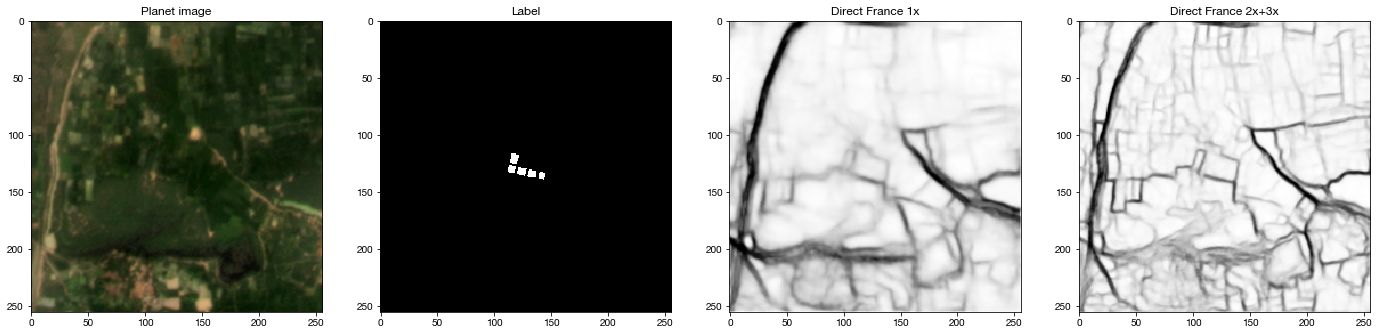

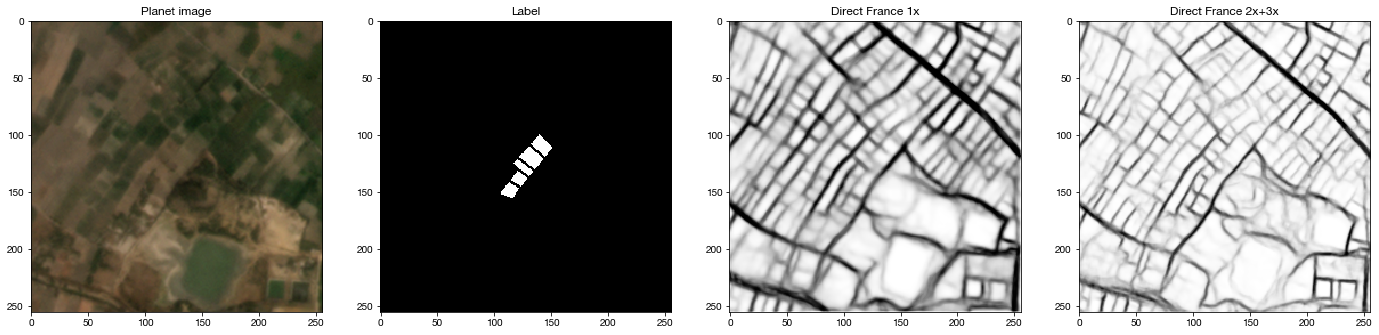

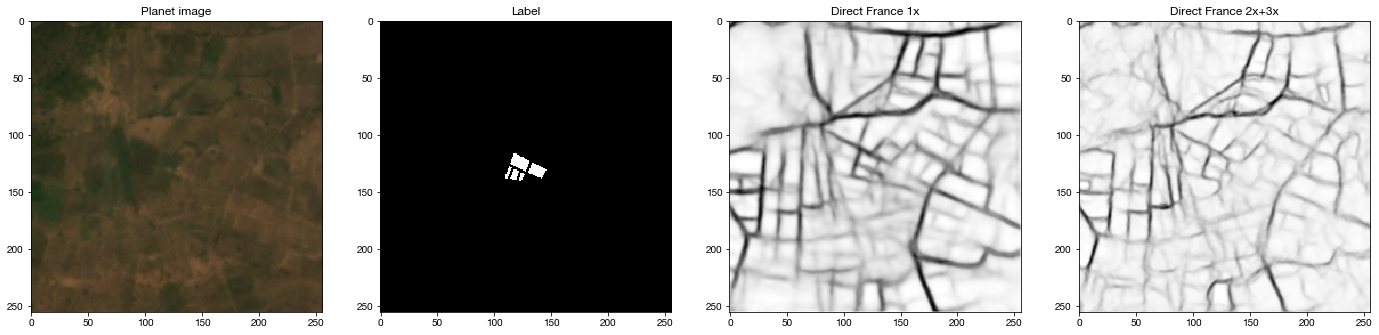

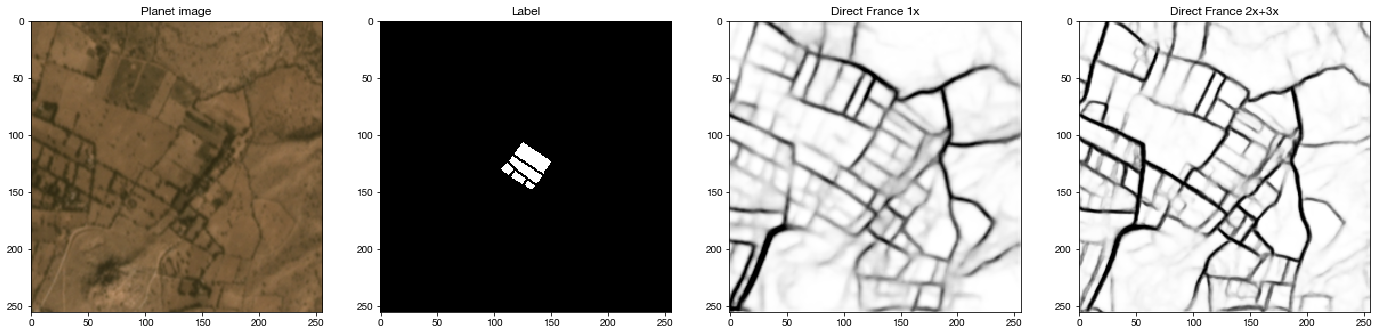

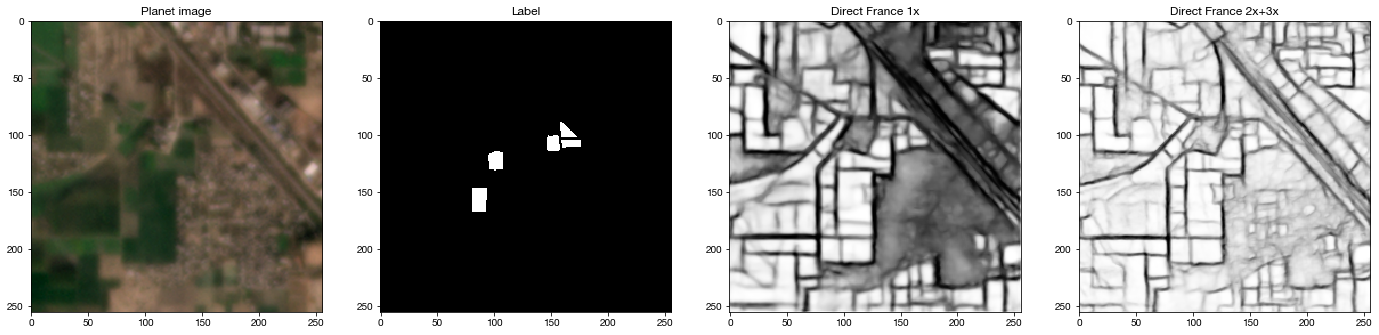

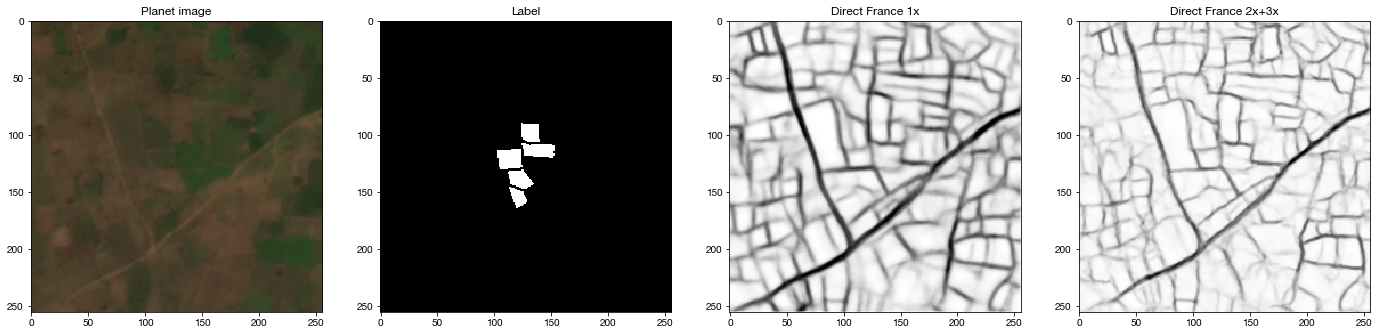

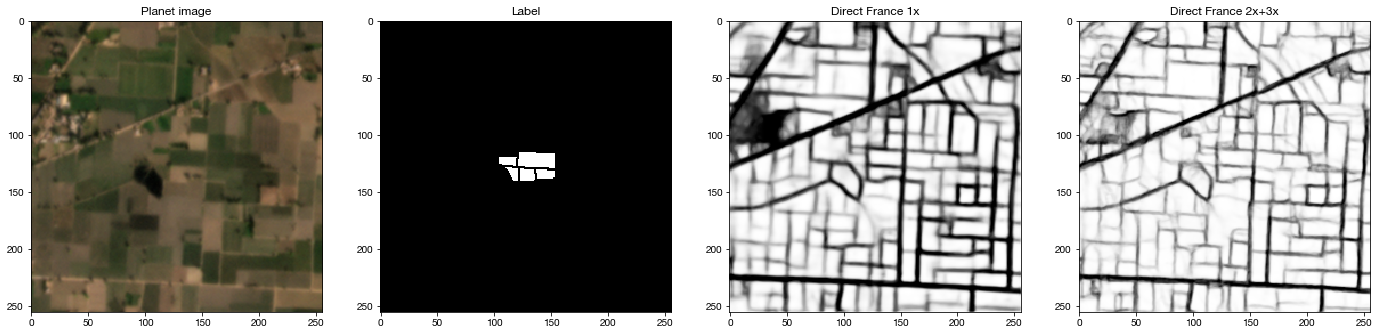

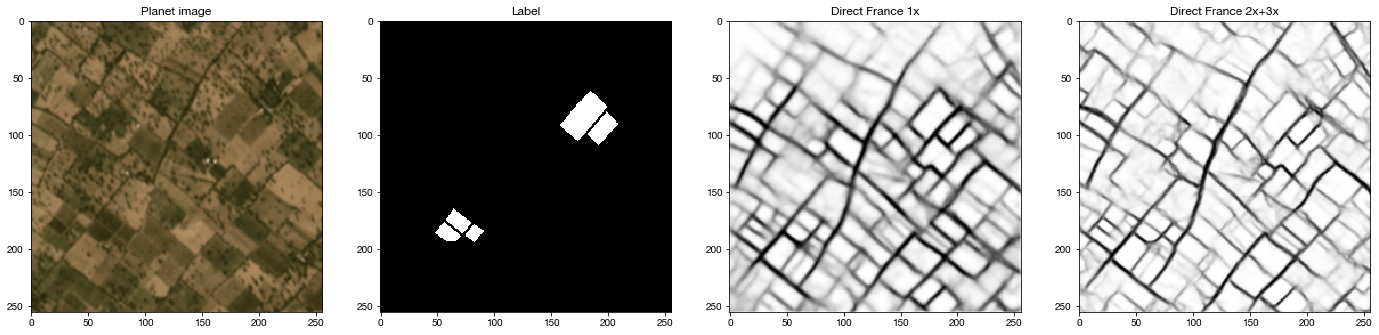

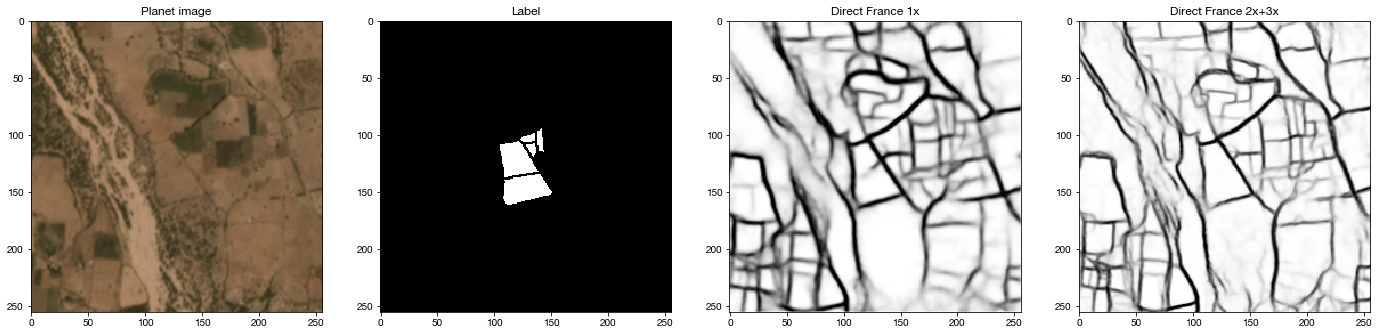

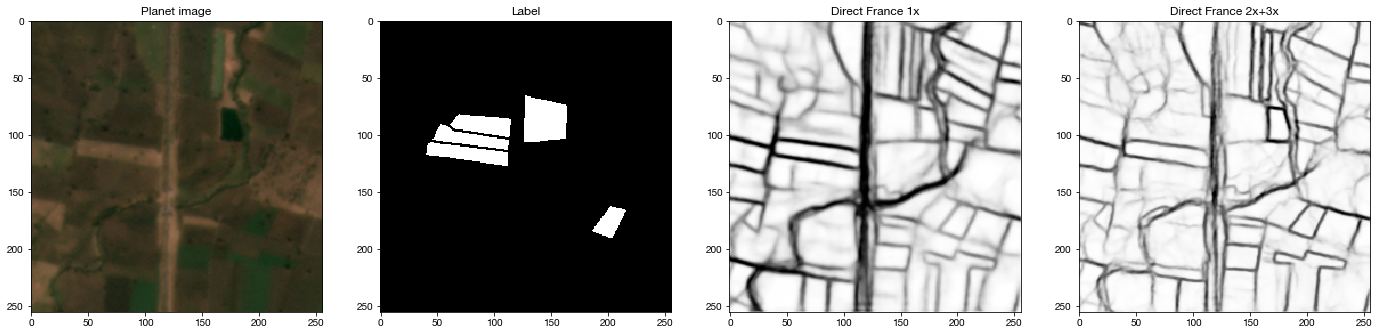

In [25]:
for image_id in val_ids[:10]:
    img = imageio.imread('../data/planet/india/GeneralBlockchain/monthly_mosaics_renamed_clipped_merged_val/2020_12/{}_2020_12.tif'.format(image_id))
    label = imageio.imread('../data/planet/india/GeneralBlockchain/extent_labels_val/{}.png'.format(image_id))
    pred1 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))
    pred2 = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/extent_predictions/{}.npy'.format(image_id))

    fig, ax = plt.subplots(1, 4, figsize=(24,6))
    ax[0].imshow(img)
    ax[1].imshow(label, cmap='Greys_r')
    ax[2].imshow(pred1, cmap='Greys_r')
    ax[3].imshow(pred2, cmap='Greys_r')
    ax[0].set_title('Planet image')
    ax[1].set_title('Label')
    ax[2].set_title('Direct France 1x')
    ax[3].set_title('Direct France 2x+3x')
    plt.show()

In [11]:
# Planet India: Best hyperparameters
results_dirs = [
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/', # France 1x
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/', # France 2x+3x
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/consensus/', # India fine-tuned 
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch/consensus/' # India from scratch
]
for results_dir in results_dirs:
    print(results_dir.split('/')[4])
    hp_df = pd.read_csv(os.path.join(results_dir, 'IoU_hyperparameter_tuning.csv'))
    print(hp_df.iloc[hp_df['mIoU'].idxmax()])

fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759
t_ext      0.500000
t_bound    0.000000
mIoU       0.416667
IoU_50     0.380187
Name: 3, dtype: float64
fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759
t_ext      0.600000
t_bound    0.100000
mIoU       0.408821
IoU_50     0.415663
Name: 7, dtype: float64
fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned
t_ext      0.500000
t_bound    0.200000
mIoU       0.542504
IoU_50     0.536145
Name: 5, dtype: float64
fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch
t_ext      0.600000
t_bound    0.200000
mIoU       0.544949
IoU_50     0.536814
Name: 8, dtype: float64


In [42]:
hp_df = pd.read_csv('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/IoU_hyperparameter_tuning.csv')
hp_df.iloc[41]

t_ext      0.500000
t_bound    0.100000
mIoU       0.328986
IoU_50     0.345361
Name: 41, dtype: float64

In [41]:
hp_df = pd.read_csv('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/IoU_hyperparameter_tuning.csv')
hp_df.iloc[41]

t_ext      0.500000
t_bound    0.100000
mIoU       0.387698
IoU_50     0.391753
Name: 41, dtype: float64

### Run on all test set

In [12]:
# run for all test fields
def get_Planet_test_set_IoUs(test_ids, model_name='fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned',
                             t_ext=0.15, t_bound=0.2):
    image_ids = test_ids

    label_dir = '../data/planet/india/GeneralBlockchain/extent_labels_test_for_IoU/'
    results_dir = '../results/india/GeneralBlockchain/{}/consensus'.format(model_name)

    IoUs = []
    field_sizes = []

    for i, image_id in enumerate(image_ids):
        if i % 100 == 0:
            print(i)
        # label_path = os.path.join(label_dir, '{}.png'.format(image_id))
        label_path = os.path.join(label_dir, '{}.npy'.format(image_id))
        if os.path.exists(label_path):
            # example_truth = imageio.imread(label_path)
            example_truth = np.load(label_path)
            extent_pred = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
            boundary_pred = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))
            img_IoUs, img_field_sizes = get_IoUs(example_truth, extent_pred, boundary_pred, t_ext=t_ext, t_bound=t_bound)
            IoUs = IoUs + img_IoUs
            field_sizes = field_sizes + img_field_sizes
            
    return IoUs, field_sizes

In [ ]:
results_dirs = [
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/consensus/', # France 1x
    '../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/consensus/', # France 2x+3x
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/consensus/', # India fine-tuned 
    '../results/india/GeneralBlockchain/fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch/consensus/' # India from scratch
]

#### Direct transfer from France, 1x

In [16]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/'
t_ext = 0.5
t_bound = 0.0
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name, t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [17]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.373
IoU_50 = 0.326


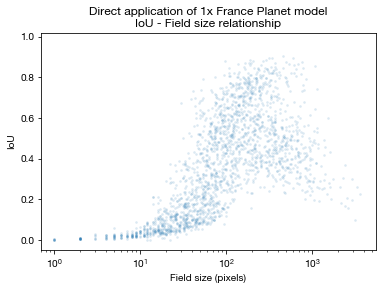

In [18]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('Direct application of 1x France Planet model\nIoU - Field size relationship')
plt.show()

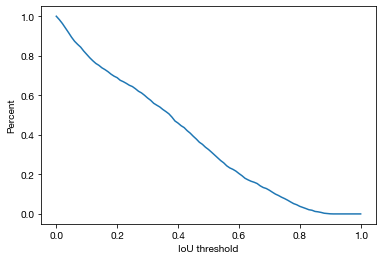

In [19]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Direct transfer from France, 2x+3x downsampled

In [17]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/'
ious2x = pd.read_csv('../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name))

model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/'
ious1x = pd.read_csv('../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name))

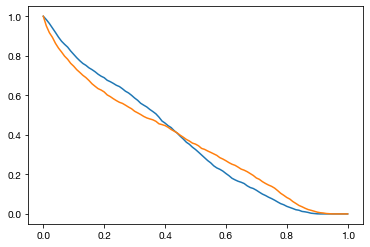

In [21]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields2x = []
percent_of_fields1x = []
for IoU_threshold in IoU_thresholds:
    percent_of_fields2x.append(np.sum(np.array(ious2x['IoU']) >= IoU_threshold) / len(ious2x['IoU']))
    percent_of_fields1x.append(np.sum(np.array(ious1x['IoU']) >= IoU_threshold) / len(ious1x['IoU']))

plt.plot(IoU_thresholds, percent_of_fields1x)
plt.plot(IoU_thresholds, percent_of_fields2x)
plt.show()

In [15]:
model_name = 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_2x-3x-downsampled_allfields_n6759/'
t_ext = 0.6
t_bound = 0.1
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [24]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.323
IoU_50 = 0.353


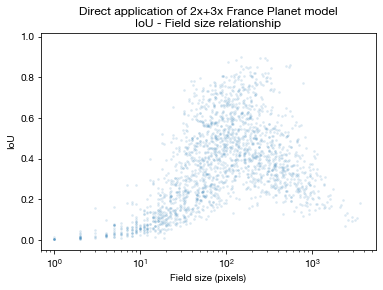

In [22]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('Direct application of 2x+3x France Planet model\nIoU - Field size relationship')
plt.show()

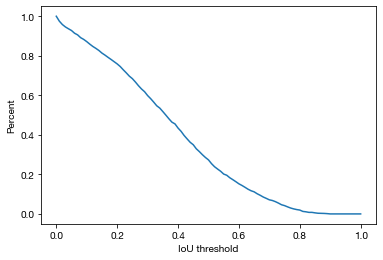

In [72]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Fine-tuned from 2x-3x France

In [25]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_2x-3x_downsampled_finetuned/'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [26]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.521
IoU_50 = 0.523


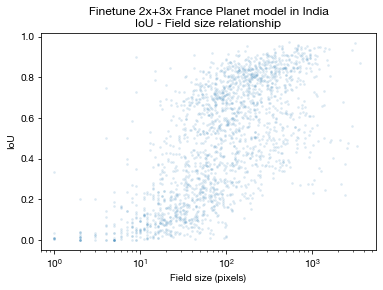

In [27]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('Finetune 2x+3x France Planet model in India\nIoU - Field size relationship')
plt.show()

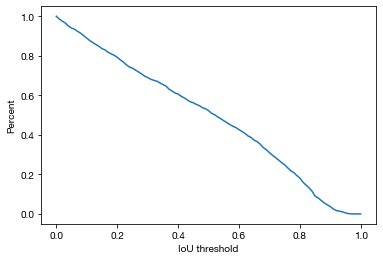

In [28]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

#### Trained from scratch in India

In [29]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [30]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.500
IoU_50 = 0.503


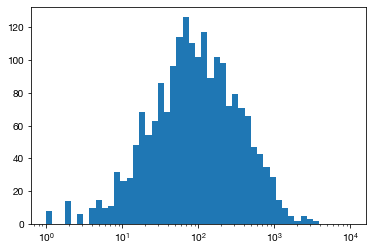

In [31]:
plt.hist(field_sizes, bins=np.logspace(0, 4))
plt.xscale('log')
plt.show()

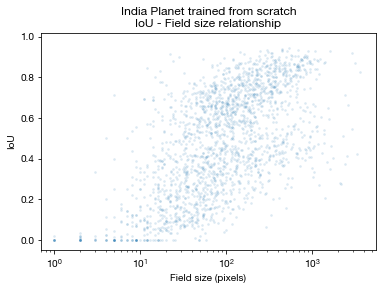

In [32]:
# field sizes - make this a heat/density map?
plt.scatter(field_sizes, IoUs, alpha=0.1, s=3)
plt.xscale('log')
plt.xlabel('Field size (pixels)')
plt.ylabel('IoU')
plt.xlim([0.7, 5500])
plt.ylim([-0.05, 1.02])
plt.title('India Planet trained from scratch\nIoU - Field size relationship')
plt.show()

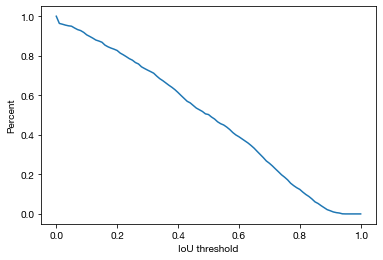

In [33]:
IoU_thresholds = np.linspace(0,1,101)
percent_of_fields = []

for IoU_threshold in IoU_thresholds:
    percent_of_fields.append(
        np.sum(np.array(IoUs) >= IoU_threshold) / len(IoUs))
    
# IoU curve
plt.plot(IoU_thresholds, percent_of_fields)
plt.xlabel('IoU threshold')
plt.ylabel('Percent')
plt.show()

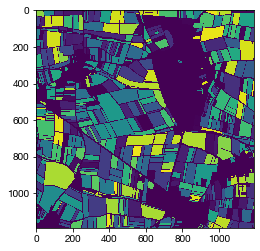

In [101]:
new_label = np.load('../data/planet/france/extent_labels/1250px/original_thickness2_for_IoU/01885.npy')
plt.imshow(new_label)
plt.show()

In [102]:
np.unique(new_label)

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
        15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,
        44,  45,  46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  80,  81,  82,  84,  85,  86,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 131, 132, 133, 134, 135, 136, 138, 140, 141, 142, 144, 145,
       147, 148, 149, 152, 154, 155, 157, 158, 161, 164, 167, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 181, 182, 184, 185, 186,
       187, 188, 190, 191, 193, 194, 196, 197, 200, 203, 204, 205, 206,
       207, 208, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

## Dataset size experiment

### Fine-tuned from France

#### n = 1000

In [37]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n1000_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [38]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.492
IoU_50 = 0.494


#### n = 400

In [39]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n400_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [40]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.498
IoU_50 = 0.499


#### n = 200

In [41]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n200_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [42]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.487
IoU_50 = 0.487


#### n = 100

In [43]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n100_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [44]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.463
IoU_50 = 0.460


#### n = 40

In [45]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n40_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [46]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.442
IoU_50 = 0.438


#### n = 20

In [47]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_bs-8_lr-0.001_n20_finetuned'
t_ext = 0.5
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [48]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.438
IoU_50 = 0.438


### Trained from scratch

#### n = 1000

In [24]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n1000_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [25]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.486
IoU_50 = 0.487


#### n = 400

In [28]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n400_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [29]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.454
IoU_50 = 0.452


#### n = 200

In [30]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n200_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [31]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.446
IoU_50 = 0.438


#### n = 100

In [32]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n100_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [33]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.426
IoU_50 = 0.418


#### n = 40

In [34]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n40_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [35]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.392
IoU_50 = 0.382


#### n = 20

In [26]:
model_name = 'fractal-resunet_12month-separate_nfilter-32_depth-6_bs-8_lr-0.001_n20_fromscratch'
t_ext = 0.6
t_bound = 0.2
IoUs, field_sizes = get_Planet_test_set_IoUs(test_ids=test_ids, model_name=model_name,
                                             t_ext=t_ext, t_bound=t_bound)
df = pd.DataFrame({
    'IoU': IoUs,
    'field_size': field_sizes
})
df.to_csv(
    '../results/india/GeneralBlockchain/{}/consensus/IoU.csv'.format(model_name),
    index=False)

0
100
200
300


In [27]:
print("mIoU   = {:0.3f}".format(np.median(IoUs)))
print("IoU_50 = {:0.3f}".format(np.sum(np.array(IoUs) >= 0.5) / len(IoUs)))

mIoU   = 0.285
IoU_50 = 0.262
